# Data prepration.

In [ ]:
from sklearn.metrics import precision_score, recall_score, classification_report
import string
from nltk.corpus import stopwords
import nltk
import re
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import pandas as pd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data loading.

In [ ]:
"""
We will start by reading the data using pandas librarie
"""
data = pd.read_csv('Tweets.csv')

A first step to take a look at the data by showing the 3 first rows of it.

In [ ]:
data.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [ ]:
print('we have {} data points'.format(data.shape[0]))

we have 14640 data points


### Data Analysis.

#### Sentiments frequency.

So each tweet is defined by a set of features the most of them are just Identifiers which we will not use as  client senetiment will be expressed in **text** column. Also the real sentiment is given in **airline_sentiment** which will be our target (label).

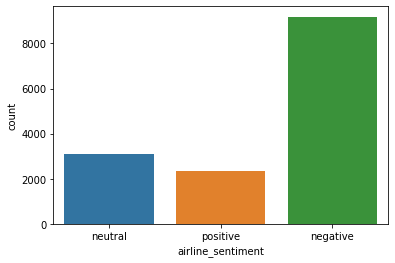

In [ ]:
import seaborn as sns
sns.countplot(x = "airline_sentiment", data = data)

By counting the number of sentiments for each class we can conclude that tweets with negative sentiments are more frequent. Therefore, a first finding will be that Machine learning models that we will build will likely predict negative sentiments with more accuracy. It will be a good point because companies care more about negative reviews in order to improve their services.

#### Tweets frequency by Companies

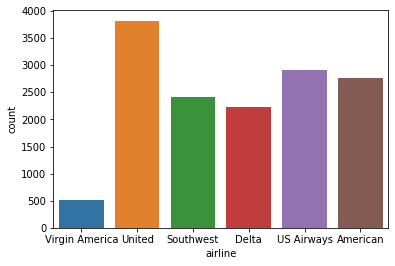

In [ ]:
ax = sns.countplot(x="airline", data=data)

From the above plot we can observe that United has the most number of flights and Virgin America has the least.

### Data cleaning

In this section we will clean the data by removing unusefull features for our problem and clean the tweets.

In [ ]:
"""
We will keep just tweets text with its sentiment
"""
data = data.drop(['tweet_id', 'airline_sentiment_confidence','negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold','retweet_count', 'tweet_coord', 'tweet_created','tweet_location',
                        'user_timezone']
                       , axis = 1)
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Our input feature will be tweet text but it need some processing steps so first we will do tokenizing the tweet and also taking tokens from second index onwards as initital to gives airline name and '@' and lowering them and later making it back a sentence.

In [ ]:
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])
def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

First we will remove neutral tweets

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data = data[data['airline_sentiment']!='neutral']
data['cleaned_tweet'] = data['text'].apply(clean_the_tweet)

data.head()
data['airline_sentiment'] = data['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
data.head()

,airline_sentiment,text,cleaned_tweet
1,1,@VirginAmerica plus you've added commercials t...,you ve added commercials to the experience tacky
3,0,@VirginAmerica it's really aggressive to blast...,s really aggressive to blast obnoxious enterta...
4,0,@VirginAmerica and it's a really big bad thing...,it s a really big bad thing about it
5,0,@VirginAmerica seriously would pay $30 a fligh...,would pay a flight for seats that didn t have ...
6,1,"@VirginAmerica yes, nearly every time I fly VX...",nearly every time i fly vx this ear worm won t...


Then we will Clean the tweets from punctuation marks

In [ ]:
data['cleaned_tweet'] = data['cleaned_tweet'].apply(text_process)
data.reset_index(drop=True, inplace = True)
data.head()

,airline_sentiment,text,cleaned_tweet
0,1,@VirginAmerica plus you've added commercials t...,added commercials experience tacky
1,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
2,0,@VirginAmerica and it's a really big bad thing...,really big bad thing
3,0,@VirginAmerica seriously would pay $30 a fligh...,would pay flight seats playing really bad thin...
4,1,"@VirginAmerica yes, nearly every time I fly VX...",nearly every time fly vx ear worm go away


### Text encoding
As Machine learning models work just with numerical values, we will encode our text tweets using TF-IDF vectorizer.

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(data.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, data['airline_sentiment'], random_state=42)

# Machine learning Models
In this section we will build 3 machine learning models : Random Forest, KNN, Logistic Regression and Adabtive bosting. We will train each model on our tweets data, the we will compare the performances in order to choose the best one. And as we will follow the same steps for each model (train/test/evaluate) we will define a common function for this purpose.

In [ ]:
def train_evaluate(machine_learning_model, X_train,X_test,y_train,y_test):
  model = machine_learning_model.fit(X_train,y_train)
  predictions = model.predict(X_test)
  print('Confusion matrix is: \n',)
  plot_confusion_matrix(model, X_test, y_test) 
  plt.show() 
  print('Classification Report \n',)
  print(classification_report(predictions,y_test))
  return recall_score(predictions,y_test), precision_score(predictions,y_test)

### Logistic Regression

Confusion matrix is: 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


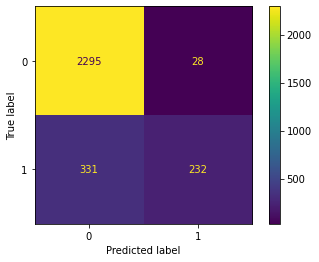

Classification Report 

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      2626
           1       0.41      0.89      0.56       260

    accuracy                           0.88      2886
   macro avg       0.70      0.88      0.75      2886
weighted avg       0.94      0.88      0.89      2886



In [ ]:
recall_LR,precision_LR = train_evaluate(LogisticRegression(),x_train,x_test,y_train,y_test)

### Random Forest

Confusion matrix is: 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


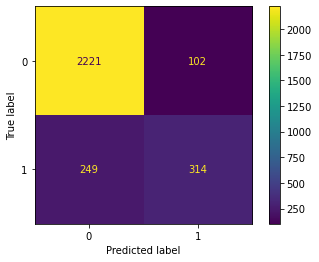

Classification Report 

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2470
           1       0.56      0.75      0.64       416

    accuracy                           0.88      2886
   macro avg       0.76      0.83      0.78      2886
weighted avg       0.90      0.88      0.89      2886



In [ ]:
recall_RF,precision_RF = train_evaluate(RandomForestClassifier(),x_train,x_test,y_train,y_test)

### Adabtive boosting

Confusion matrix is: 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


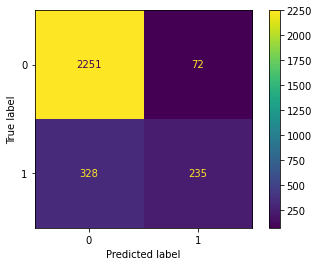

Classification Report 

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      2579
           1       0.42      0.77      0.54       307

    accuracy                           0.86      2886
   macro avg       0.69      0.82      0.73      2886
weighted avg       0.91      0.86      0.88      2886



In [ ]:
recall_ABC,precision_ABC = train_evaluate(AdaBoostClassifier(),x_train,x_test,y_train,y_test)

### Best Model

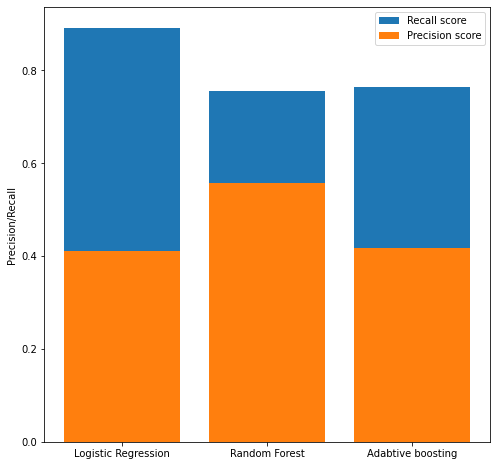

In [ ]:
models = ['Logistic Regression','Random Forest','Adabtive boosting']
pre = [precision_LR,precision_RF,precision_ABC]
rec = [recall_LR,recall_RF,recall_ABC]
plt.figure(figsize=(8,8))
plt.bar(models,rec,label='Recall score')
plt.bar(models,pre,label='Precision score')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

* Logistic regression gives a high recall with high precision of random forest.